Импорт необходимых библиотек и проверка, что tenserflow нормально встал.

In [2]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import uniform, randint

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential, regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')
print(tf.__version__)

2.19.0


## Future Engineering
Для начала, нужно посмотреть из чего в целом состоит выбранный датасет.

In [3]:
data = pd.read_csv('train.csv')
data

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17991,Green-House,Find Home,35.0,0.166,0.109,7.0,-17.100,0,0.0413,0.993000,0.824000,0.0984,0.1770,171.587,193450.0,3,6
17992,Micatone,All Gone,27.0,0.638,0.223,11.0,-10.174,0,0.0329,0.858000,0.000016,0.0705,0.3350,73.016,257067.0,4,2
17993,Smash Hit Combo,Peine perdue,34.0,0.558,0.981,4.0,-4.683,0,0.0712,0.000030,0.000136,0.6660,0.2620,105.000,216222.0,4,8
17994,Beherit,Salomon's Gate,29.0,0.215,0.805,6.0,-12.757,0,0.1340,0.001290,0.916000,0.2560,0.3550,131.363,219693.0,4,8


Как видно, он состоит из 17 столбцов, последний из которых являеться таргетным - это жанр песни от 0 до 1. Все жанры:
1. Фолк
2. Альтернатива
3. Блюз
4. Боливуд
5. Кантри
6. Хип-Хоп
7. Инди
8. Инструментальная
9. Метал
10. Поп
Первым делом давайте оценим датасет на количество пропусков и основные статистики.

In [4]:
#Данные и так оказались в числовом формате.
# numeric_cols = ['Popularity', 'energy', 'danceability', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_in min/ms']
# data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Размерность данных
print(f"Размер данных: {data.shape}")

# Типы данных
print("\nТипы данных в столбцах:")
print(data.dtypes)

# Пропуски
print("\nКоличество пропущенных значений:")
print(data.isnull().sum())

# Основные статистики
print("\nОсновные статистики числовых столбцов:")
print(data.describe())

Размер данных: (17996, 17)

Типы данных в столбцах:
Artist Name            object
Track Name             object
Popularity            float64
danceability          float64
energy                float64
key                   float64
loudness              float64
mode                    int64
speechiness           float64
acousticness          float64
instrumentalness      float64
liveness              float64
valence               float64
tempo                 float64
duration_in min/ms    float64
time_signature          int64
Class                   int64
dtype: object

Количество пропущенных значений:
Artist Name              0
Track Name               0
Popularity             428
danceability             0
energy                   0
key                   2014
loudness                 0
mode                     0
speechiness              0
acousticness             0
instrumentalness      4377
liveness                 0
valence                  0
tempo                    0
duration_in 

Дубликатов в датасете нет.

In [8]:
print(len(data))
data = data.drop_duplicates()
print(len(data))

17996
17996


До этого я хотел убрать все пропуски, но в конечном итоге пришел к тому, что лучше заполнить данные медианными значениями для каждого жанра.

In [9]:
#data_without_passes = data.copy()
#data_without_passes.dropna(inplace=True)
#print(data_without_passes.shape)

In [7]:
cols_to_fill = ['Popularity', 'key', 'instrumentalness']

# Среднее
#df[cols_to_fill] = df.groupby('Class')[cols_to_fill].transform(lambda x: x.fillna(x.mean()))

# Медиана
data[cols_to_fill] = data.groupby('Class')[cols_to_fill].transform(lambda x: x.fillna(x.median()))


Первым делом - мы не удаляем выбросы по простой причине - например громкость зависит от жанра, что очень легко проследить. Все жанры кроме 7-ого относительно громкие, выбросы также везде разные. Так например у 0, 3 и 4-ого класса они минимальны. Также и со всеми остальными параметрами!

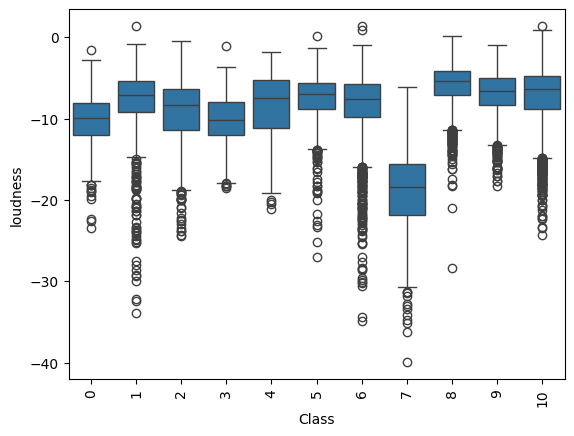

In [10]:
sns.boxplot(x='Class', y='loudness', data=data)
plt.xticks(rotation=90)
plt.show()

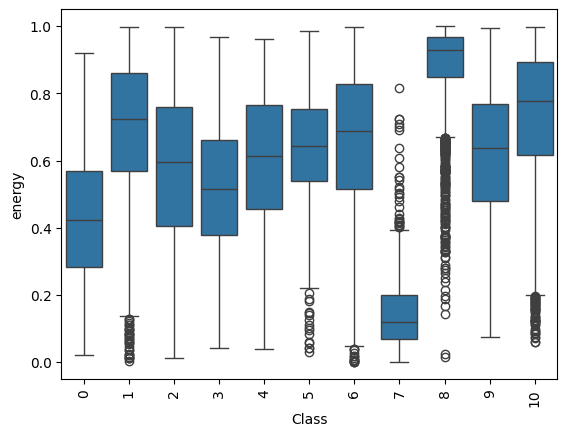

In [11]:
sns.boxplot(x='Class', y='energy', data=data)
plt.xticks(rotation=90)
plt.show()

Нечисловые столбцы:
Index(['Artist Name', 'Track Name'], dtype='object')


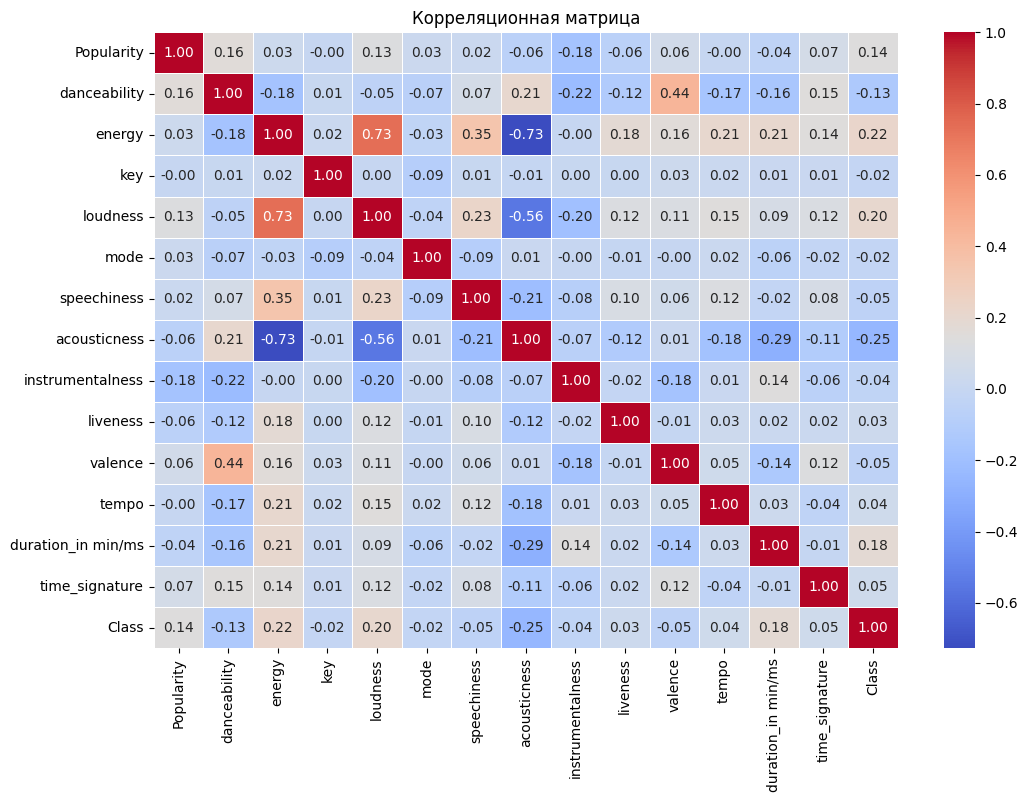

In [13]:
corr_matrix = data.select_dtypes(include=['number']).corr(method='spearman')
non_numeric_columns = data.select_dtypes(exclude=['number']).columns
df = data.drop(non_numeric_columns, axis=1)
print("Нечисловые столбцы:")
print(non_numeric_columns)

corr_matrix = df.corr(method='spearman')
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Корреляционная матрица")
plt.show()


Как можно видеть из матрицы, многие значения существенно коррелируют между собой, а значит можно постараться исключить часть из них в будущем, это будет важно при подборе параметров.

### Машинное обучение
Я решил начать со случайного леса, как с относительно не сложного алгоритма машинного обучения.

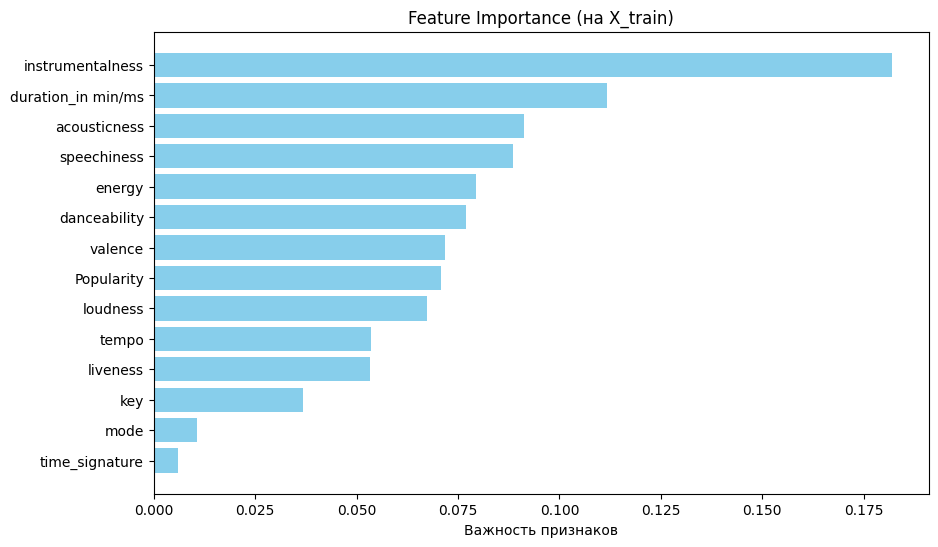

Accuracy: 0.5363888888888889
              precision    recall  f1-score   support

           0       0.76      0.76      0.76       136
           1       0.29      0.23      0.25       286
           2       0.49      0.41      0.45       281
           3       0.75      0.76      0.75        78
           4       0.81      0.79      0.80        71
           5       0.76      0.65      0.70       262
           6       0.32      0.35      0.34       500
           7       0.87      0.94      0.90       103
           8       0.57      0.52      0.54       382
           9       0.69      0.64      0.66       531
          10       0.49      0.57      0.52       970

    accuracy                           0.54      3600
   macro avg       0.62      0.60      0.61      3600
weighted avg       0.54      0.54      0.54      3600



In [14]:
features = df.drop(columns=['Class'])
target = df['Class']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

feature_importance = model.feature_importances_
sorted_idx = feature_importance.argsort()

plt.figure(figsize=(10, 6))
plt.barh(X_train.columns[sorted_idx], feature_importance[sorted_idx], color='skyblue')
plt.xlabel('Важность признаков')
plt.title('Feature Importance (на X_train)')
plt.show()

# Выбираем важные признаки на основе результата
important_features = X_train.drop(
    columns=['time_signature', 'mode', 'key', 'tempo', 'liveness', 'loudness', 'danceability', 'energy', 'valence', 'speechiness']
).columns.to_list()

X_train_selected = X_train[important_features]
X_test_selected = X_test[important_features]

# Обучаем финальную модель
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)


print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


С первой же попытки мне удалось получить неплохие результаты в 0.53, что является неплохим показателем. Но для того, чтобы быть уверенным в необходимости использования подобной модели, стоит проверить также более простую - логистическую регрессию.

In [15]:
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_model.fit(X_train_selected, y_train)
logreg_pred = logreg_model.predict(X_test_selected)

print("Логистическая регрессия:")
print("Accuracy:", accuracy_score(y_test, logreg_pred))
print(classification_report(y_test, logreg_pred))


Логистическая регрессия:
Accuracy: 0.2861111111111111
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       136
           1       0.00      0.00      0.00       286
           2       0.22      0.07      0.11       281
           3       0.00      0.00      0.00        78
           4       0.00      0.00      0.00        71
           5       0.00      0.00      0.00       262
           6       0.00      0.00      0.00       500
           7       0.20      1.00      0.34       103
           8       0.12      0.01      0.02       382
           9       0.25      0.05      0.09       531
          10       0.31      0.90      0.46       970

    accuracy                           0.29      3600
   macro avg       0.10      0.19      0.09      3600
weighted avg       0.16      0.29      0.16      3600



Логистическая регрессия, ожидаемо дала плохие результаты, тем более относительно модели случайного леса, смысла останавлваться на ней и нет.

Для модели градиентного бустинга, я сразу же решил предварительно использовать кросс валидацию, поскольку это очень сложная и тонкая в настройке модель, от гиперпараметров которой сильно зависит результат классификации.

In [11]:
param_dist = {
    'n_estimators': randint(100, 300),
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(3, 8),
    'subsample': uniform(0.8, 0.2)
}

model = GradientBoostingClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=30,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train_selected, y_train)
print("Лучшие параметры:", random_search.best_params_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Лучшие параметры: {'learning_rate': np.float64(0.012306242504141576), 'max_depth': 5, 'n_estimators': 158, 'subsample': np.float64(0.8799721943430512)}


После получения параметров, создаём новую модель и проверяем её.

In [27]:
best_gb_model = GradientBoostingClassifier(
    learning_rate=0.123,
    max_depth=5,
    n_estimators=158,
    subsample=0.88,
    random_state=42
)

best_gb_model.fit(X_train, y_train)

y_pred_best = best_gb_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

Accuracy: 0.6241666666666666
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       136
           1       0.36      0.21      0.26       286
           2       0.65      0.54      0.59       281
           3       0.86      0.83      0.84        78
           4       0.84      0.73      0.78        71
           5       0.89      0.82      0.85       262
           6       0.44      0.45      0.44       500
           7       0.91      0.96      0.93       103
           8       0.68      0.62      0.65       382
           9       0.76      0.69      0.73       531
          10       0.54      0.68      0.60       970

    accuracy                           0.62      3600
   macro avg       0.70      0.67      0.68      3600
weighted avg       0.63      0.62      0.62      3600



Модель показала потрясающие результаты в 0.62 accuracy, что превосходит все использованные до этого модели.

## Нейросеть
Я решил также попробовать обучить нейросеть

In [18]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(X_test)

y_train_cat = to_categorical(y_train, num_classes=11)
y_test_cat = to_categorical(y_test, num_classes=11)

def build_multiclass_model():
    model = Sequential([
        layers.Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],)),
        layers.Dense(64, activation='relu'),
        layers.Dense(11, activation='softmax')  # 11 классов → softmax
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_multiclass_model()
history = model.fit(
    x_train_scaled, y_train_cat,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

y_pred_proba = model.predict(x_test_scaled)
y_pred = np.argmax(y_pred_proba, axis=1)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Epoch 1/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3502 - loss: 1.8839 - val_accuracy: 0.4910 - val_loss: 1.3663
Epoch 2/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5084 - loss: 1.3290 - val_accuracy: 0.4983 - val_loss: 1.3308
Epoch 3/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5050 - loss: 1.3106 - val_accuracy: 0.4955 - val_loss: 1.3162
Epoch 4/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5259 - loss: 1.2617 - val_accuracy: 0.4990 - val_loss: 1.3000
Epoch 5/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5175 - loss: 1.2596 - val_accuracy: 0.5038 - val_loss: 1.2969
Epoch 6/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5282 - loss: 1.2325 - val_accuracy: 0.5115 - val_loss: 1.2836
Epoch 7/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5206 - loss: 1.2479 - val_accuracy: 0.5104 - val_loss: 1.2828
Epoch 8/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5346 - loss: 1.2166 - val_accuracy: 0.

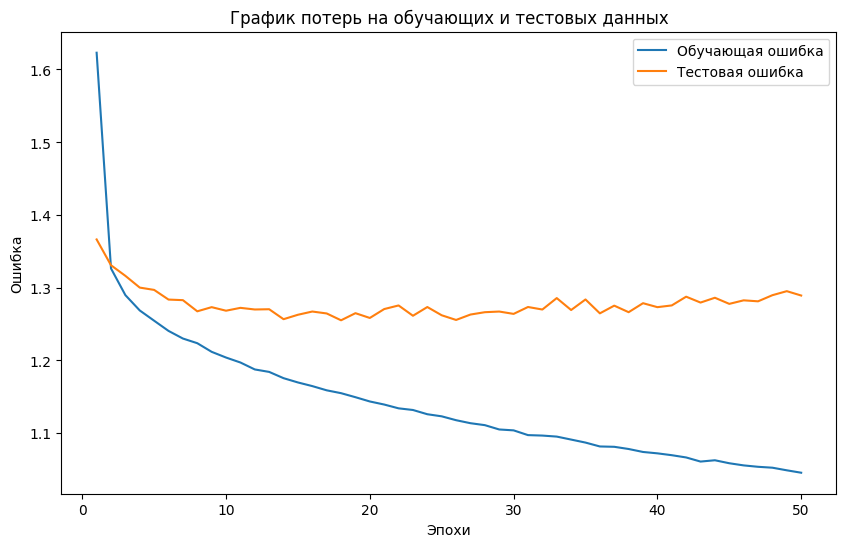

In [21]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), train_loss, label='Обучающая ошибка')
plt.plot(range(1, 51), val_loss, label='Тестовая ошибка')
plt.title('График потерь на обучающих и тестовых данных')
plt.xlabel('Эпохи')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

Первая модель, ожидаемо не дала хорошего результата, поэтому я решил её улучшить. На графике очевидна переобученность модели, так что я изменил её таким образом, чтобы обучение в нужный момент останавливалось.

In [22]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(X_test)

y_train_cat = to_categorical(y_train, num_classes=11)
y_test_cat = to_categorical(y_test, num_classes=11)


def build_multiclass_model():
    model = Sequential([
        layers.Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],),
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu',
                     kernel_regularizer=regularizers.l2(0.001)),
            layers.Dropout(0.3),
        layers.Dense(11, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_multiclass_model()

early_stop = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = model.fit(
    x_train_scaled, y_train_cat,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

y_pred_proba = model.predict(x_test_scaled)
y_pred = np.argmax(y_pred_proba, axis=1)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Epoch 1/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2806 - loss: 2.1242 - val_accuracy: 0.4757 - val_loss: 1.5321
Epoch 2/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4419 - loss: 1.6007 - val_accuracy: 0.4920 - val_loss: 1.4428
Epoch 3/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4576 - loss: 1.5297 - val_accuracy: 0.5028 - val_loss: 1.4158
Epoch 4/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4719 - loss: 1.4938 - val_accuracy: 0.5000 - val_loss: 1.3996
Epoch 5/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4729 - loss: 1.4629 - val_accuracy: 0.5056 - val_loss: 1.3849
Epoch 6/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4852 - loss: 1.4469 - val_accuracy: 0.4983 - val_loss: 1.3740
Epoch 7/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4834 - loss: 1.4329 - val_accuracy: 0.5042 - val_loss: 1.3625
Epoch 8/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4815 - loss: 1.4255 - val_accuracy: 0.

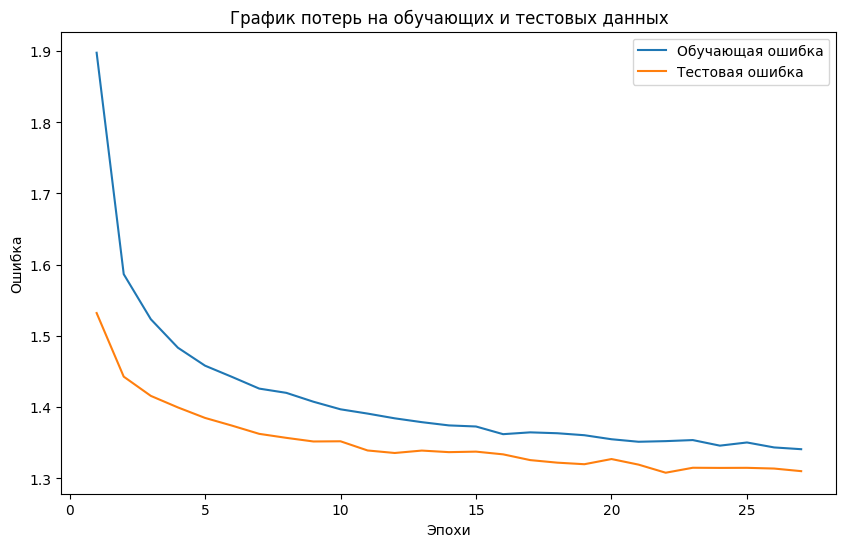

In [24]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_ran = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_ran, train_loss, label='Обучающая ошибка')
plt.plot(epochs_ran, val_loss, label='Тестовая ошибка')
plt.title('График потерь на обучающих и тестовых данных')
plt.xlabel('Эпохи')
plt.ylabel('Ошибка')
plt.legend()
plt.show()


После изменений, модель показала гараздо более качественные результаы, но она все ещё не идеальна, так что я решил сделать третьй подход, немного подкрутив парамерты модели.

In [25]:
# Масштабируем признаки
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(X_test)

# Преобразуем метки классов в one-hot-вектор
y_train_cat = to_categorical(y_train, num_classes=11)
y_test_cat = to_categorical(y_test, num_classes=11)


def build_multiclass_model():
    model = Sequential([
        layers.Dense(128, activation='relu', input_shape=(x_train_scaled.shape[1],),
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu',
                     kernel_regularizer=regularizers.l2(0.001)),
            layers.Dropout(0.2),
        layers.Dense(11, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Инициализация и обучение модели
model = build_multiclass_model()

early_stop = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = model.fit(
    x_train_scaled, y_train_cat,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Получаем предсказанные классы
y_pred_proba = model.predict(x_test_scaled)
y_pred = np.argmax(y_pred_proba, axis=1)

# Оценка
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))



Epoch 1/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3722 - loss: 1.9403 - val_accuracy: 0.4951 - val_loss: 1.4807
Epoch 2/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4761 - loss: 1.5133 - val_accuracy: 0.4955 - val_loss: 1.4199
Epoch 3/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4924 - loss: 1.4480 - val_accuracy: 0.5035 - val_loss: 1.3990
Epoch 4/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5065 - loss: 1.4076 - val_accuracy: 0.5069 - val_loss: 1.3758
Epoch 5/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5072 - loss: 1.3893 - val_accuracy: 0.5122 - val_loss: 1.3620
Epoch 6/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5172 - loss: 1.3457 - val_accuracy: 0.5181 - val_loss: 1.3486
Epoch 7/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5233 - loss: 1.3470 - val_accuracy: 0.5139 - val_loss: 1.3378
Epoch 8/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5156 - loss: 1.3354 - val_accuracy: 0.

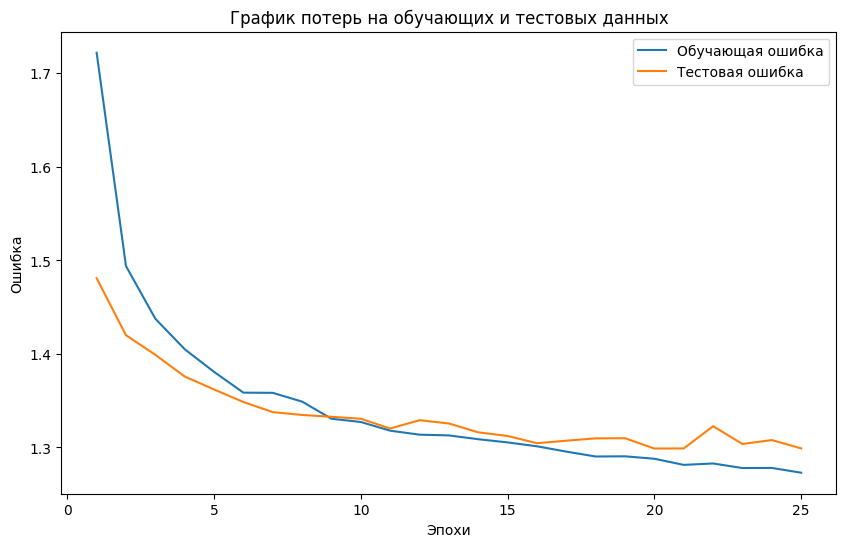

In [26]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_ran = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_ran, train_loss, label='Обучающая ошибка')
plt.plot(epochs_ran, val_loss, label='Тестовая ошибка')
plt.title('График потерь на обучающих и тестовых данных')
plt.xlabel('Эпохи')
plt.ylabel('Ошибка')
plt.legend()
plt.show()


Модель снова оказалась лучше, но крайне незначительно.

## Вывод
В ходе данной работы бы лпроизведён Future Engineering для выявления особенносте датасета, одним из главных действий данного этапа, стало заполнение пропусков медианными значениями для каждого жанра.
В последующем этапе работы я работал с алгоритмами машинного обучения, главным успехом которого стало использование градиентного бустинга с кросс валидацией, который показал отличные результаты. Остальные алгоритмы были не настолько эффективными и не требут столь тщательного внимания.
Последним этапом работы было обучение нейросети. Несмотря на улучшения и работу над ней, она так и не смогла показать результатов выше, чем планка установленная алгоритмом градиентного бустинга.

